## Faz Tahmini Algoritması

In [1]:
import cirq
import numpy as np
from matplotlib import pyplot

In [2]:
# Bir Ters QFT Devresi oluşturur.
def make_qft_inverse(qubits):
    qreg = list(qubits)[::-1]
    while len(qreg) > 0:
        q_head = qreg.pop(0)
        yield cirq.H(q_head)
        for i, qubit in enumerate(qreg):
            yield (cirq.CZ ** (-1 / 2 ** (i + 1)))(qubit, q_head)

In [3]:
theta = 0.15
max_nvals = 16
nvals = np.arange(1, max_nvals)

In [4]:
# Theta açısının faz kapısı
U = cirq.Z ** (2 * theta)

# Ancila kubiti için başlangıç durumu (Kapı seçiniz)
prepare_eigenstate_gate = cirq.X

In [5]:
estimates = []
for n in nvals:
    # Her bir döngüde yeni devre gerekiyor.
    qubits = cirq.LineQubit.range(n)
    u_bit = cirq.NamedQubit('u')
    
    # Her kubite Hadamard uygulanır. 
    phase_estimator = cirq.Circuit(cirq.H.on_each(*qubits))
    
    # Kontrollü-U kapılarını belirli açılarda uygular.
    for i, bit in enumerate(qubits):
        phase_estimator.append(cirq.ControlledGate(U).on(bit, u_bit) ** (2 ** (n - 1 - i)))
        
    # Ters kuantum fourier dönüşümü tersten yerleştirilir. 
    phase_estimator.append(make_qft_inverse(qubits[::-1]))

    # Ancila kubiti için başlangıç durumu seçilir.
    phase_estimator.insert(0, prepare_eigenstate_gate.on(u_bit))

    # Kubitlere ölçüm eklenir.
    phase_estimator.append(cirq.measure(*qubits, key='m'))

    # Simülasyon başlatılır.
    sim = cirq.Simulator()
    result = sim.run(phase_estimator, repetitions=1024)

    # Ölçüm sonuçlarına göre bir ortalama bir theta değeri hesaplanır.
    theta_estimates = np.sum(2**np.arange(n)*result.measurements['m'], axis=1)/2**n
    estimates.append(theta_estimates[0])

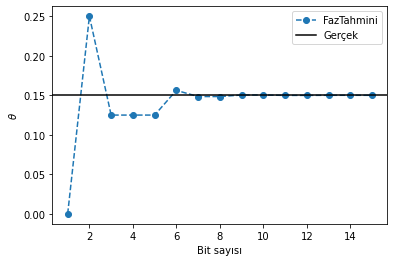

In [6]:
pyplot.plot(nvals, estimates, "--o", label="FazTahmini")
pyplot.axhline(theta, label="Gerçek", color="black")
pyplot.legend()
pyplot.xlabel("Bit sayısı")
pyplot.ylabel(r"$\theta$");
